note:可以考慮用模擬退火演算法來決定主題數目阿

gcloud 已安裝


Updated property [core/project].


已設定專案為: fakenewsbda
防火牆規則已存在，跳過創建。
Compute Engine 實例 lda-analysis-instance 已存在，跳過創建。
Hit:1 https://deb.debian.org/debian bullseye InRelease
Hit:2 https://deb.debian.org/debian-security bullseye-security InRelease
Hit:3 https://deb.debian.org/debian bullseye-updates InRelease
Hit:4 https://deb.debian.org/debian bullseye-backports InRelease
Hit:5 https://packages.cloud.google.com/apt google-compute-engine-bullseye-stable InRelease
Hit:6 https://packages.cloud.google.com/apt cloud-sdk-bullseye InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
docker.io is already the newest version (20.10.5+dfsg1-1+deb11u3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Docker 安裝完成。
檢查 Docker 鏡像是否存在...
3.12.3: Pulling from library/python
Digest: sha256:3966b81808d864099f802080d897cef36c01550472ab3955fdd716d1c665acd6
Status: Image is up to date for python:3.12.3
docker.io/library/python:3.12.3
Docker 鏡像拉取成功。
34fcb88f7a4fcad

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/16 10:38:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building prefix dict from the default dictionary ...                (0 + 4) / 4]
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 2.230 seconds.
Prefix dict has been built successfully.
Loading model cost 2.301 seconds.
Prefix dict has been built successfully.
Loading model cost 2.365 seconds.
Prefix dict has been built successfully.
Loading model cost 2.483 seconds.
Prefix dict has been built successfully.
25/01/16 10:39:36 W

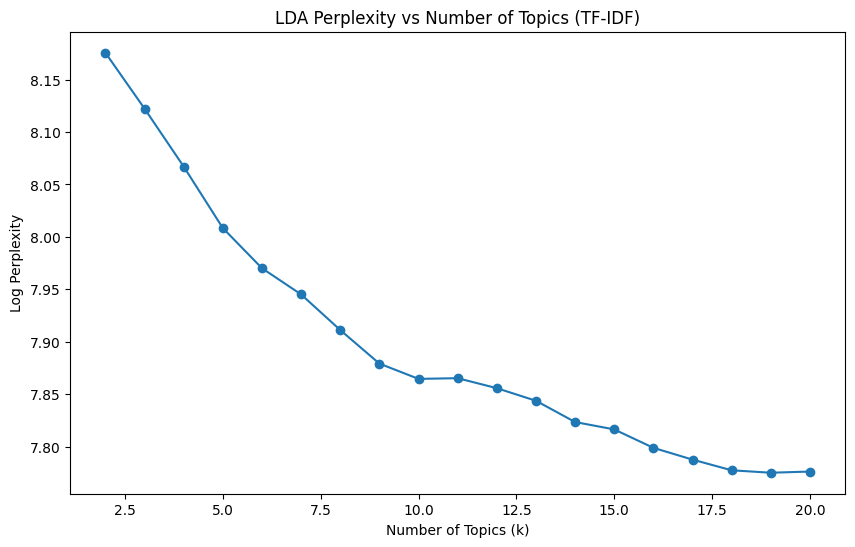

LDA 主題分析結果：
主題 0: 中國(0.0113), 機場(0.011), 登錄(0.0064), 港澳(0.0063), 美國(0.005), 發射(0.005), 金門(0.005), 導彈(0.0046), 飛彈(0.0045), 中共(0.0045)
主題 1: 口罩(0.0163), 民防(0.0138), 風(0.0117), 颱(0.0111), 龍(0.0084), 配偶(0.0083), 夏威夷(0.0082), 奧運(0.0079), 選手(0.0075), 巴黎(0.007)
主題 2: 香蕉(0.0192), 紐約(0.0139), 路肩(0.0108), 催熟(0.0099), 道路交通(0.0084), 駕照(0.0083), 公里(0.0076), 地鐵(0.0076), 交通(0.0075), 道路(0.0072)
主題 3: 投票(0.0184), 俄羅斯(0.017), 烏克蘭(0.0156), 總統(0.0081), 身分(0.0066), 俄(0.0062), 印尼(0.0061), 土耳其(0.0058), 印度(0.0056), 哈佛(0.0052)
主題 4: 爆炸(0.0149), 洋蔥(0.0148), 消毒(0.0134), 電動車(0.0107), 大蒜(0.0094), 籽(0.0083), 寄生(0.0082), 電壓(0.0082), 瓦斯(0.0073), 草莓(0.0069)
主題 5: 疫苗(0.0155), 病毒(0.0121), 新冠(0.0111), 感染(0.0099), 接種(0.0074), 免疫(0.0067), 治療(0.0064), 瑞德(0.0061), 重症(0.0059), 按摩(0.0056)
主題 6: 色素(0.0132), 雞(0.0102), 蛋(0.0086), 添加(0.0077), 蛋殼(0.0066), 糖尿病(0.0064), 橄欖油(0.0063), 冰箱(0.0054), 水果(0.0051), 腳(0.005)
主題 7: 美國(0.007), 疫苗(0.006), 以色列(0.0056), 課綱(0.0055), 電價(0.0052), 日本(0.0049), 政府(0.0049), 中國(0.0042), 歷史(0.0038), 拜登(0.0

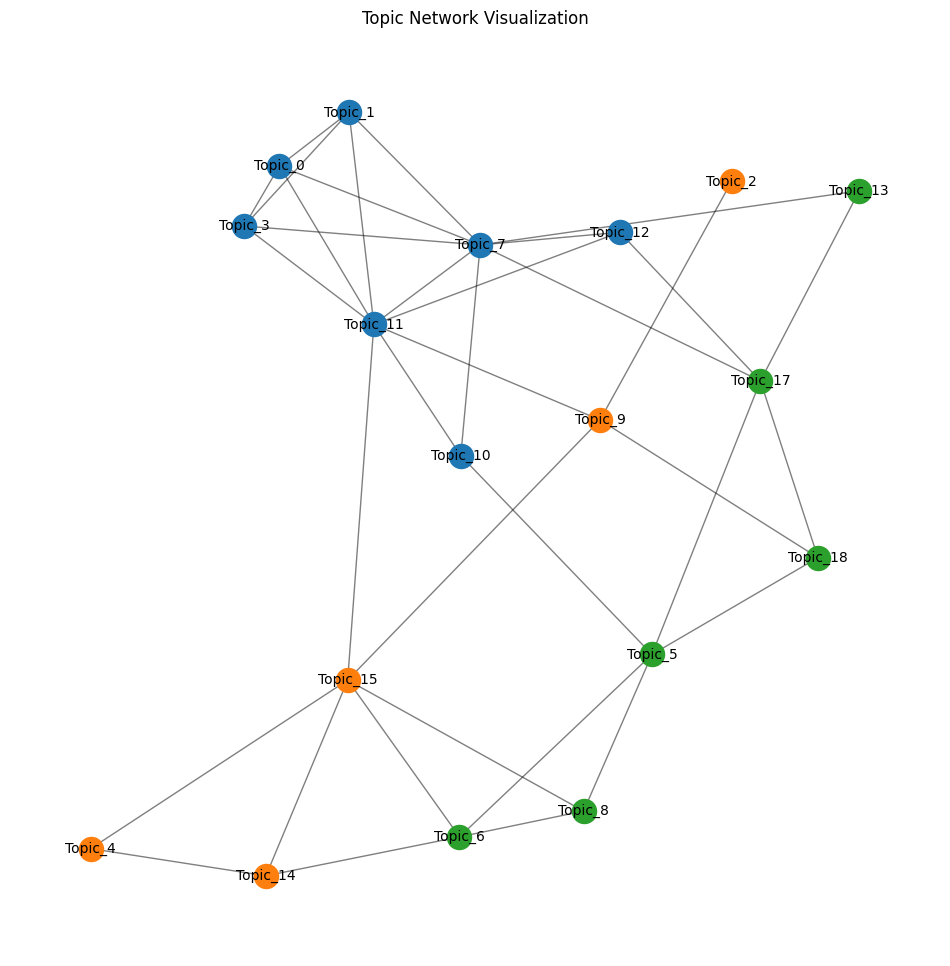

In [1]:
import os
import subprocess
import sys
import jieba
import re
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from community import community_louvain
import matplotlib.colors as mcolors

# 檢查 gcloud 是否安裝並設定專案
def check_gcloud(project_id):
    """檢查 gcloud 是否安裝並設定專案"""
    try:
        subprocess.run(["gcloud", "--version"], check=True, stdout=subprocess.PIPE)
        print("gcloud 已安裝")

        # 設定 gcloud 專案
        subprocess.run(["gcloud", "config", "set", "project", project_id], check=True)
        print(f"已設定專案為: {project_id}")
    except FileNotFoundError:
        print("gcloud 未安裝，請先安裝並配置。")
        sys.exit(1)
    except subprocess.CalledProcessError as e:
        print(f"設定 gcloud 專案失敗: {e}")
        sys.exit(1)

# 設置防火牆規則以允許 SSH
def setup_firewall():
    """設置防火牆規則以允許 SSH"""
    try:
        result = subprocess.run(
            ["gcloud", "compute", "firewall-rules", "list", "--filter", "name=default-allow-ssh"],
            check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        # 如果規則已存在，跳過創建
        if "default-allow-ssh" in result.stdout:
            print("防火牆規則已存在，跳過創建。")
            return

        # 創建防火牆規則
        subprocess.run([
            "gcloud", "compute", "firewall-rules", "create", "default-allow-ssh",
            "--allow", "tcp:22"
        ], check=True)
        print("防火牆規則已設置，允許 SSH 存取。")
    except subprocess.CalledProcessError as e:
        print(f"設置防火牆規則失敗: {e}")
        sys.exit(1)

# 創建 Compute Engine 實例
def create_compute_instance(instance_name, zone, machine_type, image_project, image_family):
    """創建 Compute Engine 實例"""
    try:
        # 檢查實例是否已存在
        result = subprocess.run(
            ["gcloud", "compute", "instances", "list", "--filter", f"name={instance_name}"],
            check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        if instance_name in result.stdout:
            print(f"Compute Engine 實例 {instance_name} 已存在，跳過創建。")
            return

        # 創建新的實例
        subprocess.run([
            "gcloud", "compute", "instances", "create", instance_name,
            "--zone", zone,
            "--machine-type", machine_type,
            "--image-project", image_project,
            "--image-family", image_family,
            "--boot-disk-size", "50GB"
        ], check=True)
        print(f"Compute Engine 實例 {instance_name} 創建完成。")
    except subprocess.CalledProcessError as e:
        print(f"創建 Compute Engine 實例失敗: {e}")
        sys.exit(1)

# 在實例中安裝 Docker
def setup_docker(instance_name, zone):
    """在實例中安裝 Docker"""
    try:
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", "sudo apt-get update && sudo apt-get install -y docker.io"
        ], check=True)
        print("Docker 安裝完成。")
    except subprocess.CalledProcessError as e:
        print(f"安裝 Docker 失敗: {e}")
        sys.exit(1)

# 驗證 Docker 鏡像是否可用
def validate_docker_image(instance_name, zone, docker_image):
    """檢查 Docker 鏡像是否有效"""
    try:
        print("檢查 Docker 鏡像是否存在...")
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", f"sudo docker pull {docker_image}"
        ], check=True)
        print("Docker 鏡像拉取成功。")
    except subprocess.CalledProcessError as e:
        print(f"Docker 鏡像無法拉取: {e}")
        print("請確保提供的 Docker 鏡像名稱正確，或進行 `docker login` 以獲取權限。")
        sys.exit(1)

# 部署 Docker 容器
def deploy_docker_container(instance_name, zone, docker_image):
    """部署 Docker 容器"""
    try:
        validate_docker_image(instance_name, zone, docker_image)

        deploy_command = f"sudo docker run -d {docker_image}"
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", deploy_command
        ], check=True)
        print("Docker 容器已部署並運行。")
    except subprocess.CalledProcessError as e:
        print(f"部署 Docker 容器失敗: {e}")
        sys.exit(1)

# 初始化 SparkSession
def initialize_spark():
    """初始化 SparkSession"""
    return SparkSession.builder.appName("PySpark LDA Analysis with TF-IDF").getOrCreate()

# 從文件中讀取停用詞
def load_stopwords(filepath):
    """從文件中讀取停用詞"""
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            return set(line.strip() for line in file)
    except FileNotFoundError:
        print(f"停用詞文件 {filepath} 未找到，請確認路徑是否正確。")
        sys.exit(1)

# 文本處理與分詞
def process_text(text, stopwords):
    """文本處理與分詞"""
    if text is None:
        return []
    words = jieba.cut(re.sub(r"[^\u4e00-\u9fa5]", "", text))
    return [word for word in words if word not in stopwords]

# 執行 LDA 分析
def lda_analysis(spark, csv_path, stopwords_path):
    """執行 LDA 分析"""
    stopwords = load_stopwords(stopwords_path)
    process_text_udf = udf(lambda text: process_text(text, stopwords), ArrayType(StringType()))

    # 加載數據
    data = spark.read.csv(csv_path, header=True, inferSchema=True)
    data = data.select('title', 'body').dropna()

    # 分詞與向量化
    data = data.withColumn("filtered_words", process_text_udf(data["body"]))
    vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=5000, minDF=5)
    vectorized_model = vectorizer.fit(data)
    vectorized_data = vectorized_model.transform(data)

    # 計算 TF-IDF
    idf = IDF(inputCol="features", outputCol="tfidf_features")
    idf_model = idf.fit(vectorized_data)
    tfidf_data = idf_model.transform(vectorized_data)

    # 計算困惑度並選擇最佳主題數量
    k_values = range(2, 21)
    perplexities = []
    for k in k_values:
        lda = LDA(k=k, maxIter=10, featuresCol="tfidf_features")
        model = lda.fit(tfidf_data)
        perplexities.append(model.logPerplexity(tfidf_data))

    # 繪製困惑度曲線
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, perplexities, marker="o")
    plt.title("LDA Perplexity vs Number of Topics (TF-IDF)")
    plt.xlabel("Number of Topics (k)")
    plt.ylabel("Log Perplexity")
    plt.show()

    # 選擇最佳主題數量
    optimal_k = k_values[np.argmin(perplexities)]
    lda = LDA(k=optimal_k, maxIter=10, featuresCol="tfidf_features")
    lda_model = lda.fit(tfidf_data)

    # 打印主題結果
    topics = lda_model.describeTopics(10).toPandas()
    vocab_list = vectorized_model.vocabulary
    topics["terms"] = topics["termIndices"].apply(lambda indices: [vocab_list[idx] for idx in indices])
    topics["weights"] = topics["termWeights"].apply(lambda weights: [round(w, 4) for w in weights])

    print("LDA 主題分析結果：")
    for i, row in topics.iterrows():
        keywords_with_weights = ", ".join(
            [f"{term}({weight})" for term, weight in zip(row["terms"], row["weights"])]
        )
        print(f"主題 {i}: {keywords_with_weights}")

    doc_topics = lda_model.transform(tfidf_data)
    doc_topics_pd = doc_topics.select("title", "topicDistribution").toPandas()
    doc_topics_pd["topicDistribution"] = doc_topics_pd["topicDistribution"].apply(
        lambda x: np.array(x, dtype=np.float64)
    )

    return lda_model, doc_topics_pd

# 可視化主題網絡
def visualize_topics(doc_topics_pd):
    """可視化主題網絡"""
    doc_topic_matrix = np.array(doc_topics_pd["topicDistribution"].tolist())
    cosine_sim = cosine_similarity(doc_topic_matrix.T)
    G = nx.Graph()

    # 建立網絡圖
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            if cosine_sim[i, j] > 0.1:
                G.add_edge(f"Topic_{i}", f"Topic_{j}", weight=cosine_sim[i, j])

    # 社區檢測
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    # 視覺化網絡圖
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 12))
    communities = nx.get_node_attributes(G, 'community')
    unique_communities = set(communities.values())
    color_map = list(mcolors.TABLEAU_COLORS.values())

    for community in unique_communities:
        nodes = [node for node in G.nodes if communities[node] == community]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=300,
                               node_color=color_map[community % len(color_map)])

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Topic Network Visualization")
    plt.axis('off')
    plt.show()

# 主程序入口
def main():
    """主程序"""
    project_id = "fakenewsbda"
    instance_name = "lda-analysis-instance"
    zone = "us-central1-a"
    machine_type = "e2-standard-4"
    image_project = "debian-cloud"
    image_family = "debian-11"
    docker_image = "python:3.12.3"

    # 初始化 GCP 環境
    check_gcloud(project_id)
    setup_firewall()
    create_compute_instance(instance_name, zone, machine_type, image_project, image_family)
    setup_docker(instance_name, zone)
    deploy_docker_container(instance_name, zone, docker_image)

    # 啟動 Spark 和執行分析
    spark = initialize_spark()
    csv_path = "/home/rrrrryeedie/final_sorted_output.csv"
    stopwords_path = "/home/rrrrryeedie/stopwords.txt"
    lda_model, doc_topics_pd = lda_analysis(spark, csv_path, stopwords_path)
    visualize_topics(doc_topics_pd)

if __name__ == "__main__":
    main()


gcloud 已安裝


Updated property [core/project].


已設定專案為: fakenewsbda
防火牆規則已存在，跳過創建。
Compute Engine 實例 lda-analysis-instance 已存在，跳過創建。
Hit:1 https://packages.cloud.google.com/apt google-compute-engine-bullseye-stable InRelease
Hit:2 https://deb.debian.org/debian bullseye InRelease
Hit:3 https://packages.cloud.google.com/apt cloud-sdk-bullseye InRelease
Hit:4 https://deb.debian.org/debian-security bullseye-security InRelease
Hit:5 https://deb.debian.org/debian bullseye-updates InRelease
Hit:6 https://deb.debian.org/debian bullseye-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
docker.io is already the newest version (20.10.5+dfsg1-1+deb11u3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Docker 安裝完成。
檢查 Docker 鏡像是否存在...
3.12.3: Pulling from library/python
Digest: sha256:3966b81808d864099f802080d897cef36c01550472ab3955fdd716d1c665acd6
Status: Image is up to date for python:3.12.3
docker.io/library/python:3.12.3
Docker 鏡像拉取成功。
e94e568cb0a3959

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/16 12:09:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building prefix dict from the default dictionary ...                (0 + 4) / 4]
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.995 seconds.
Prefix dict has been built successfully.
Loading model cost 1.882 seconds.
Prefix dict has been built successfully.
Loading model cost 1.956 seconds.
Prefix dict has been built successfully.
Loading model cost 1.645 seconds.
Prefix dict has been built successfully.
25/01/1

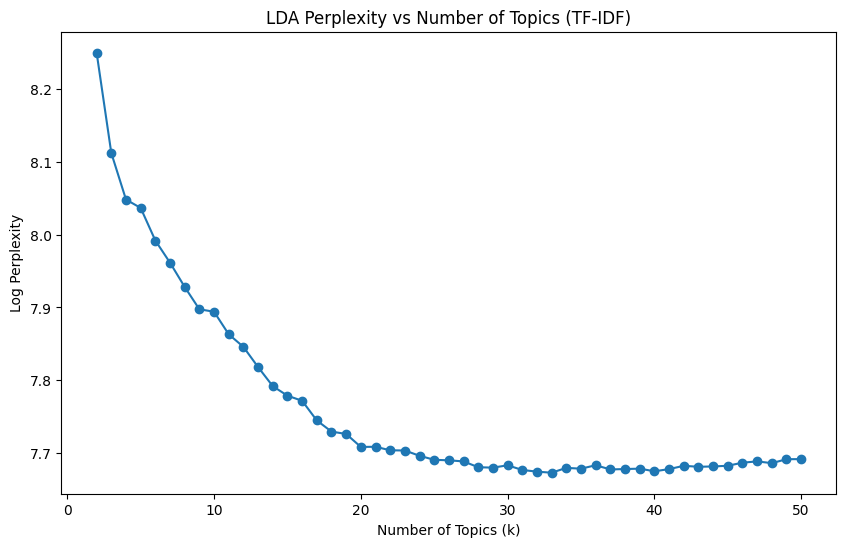

LDA 主題分析結果：
主題 0: 瑞德(0.0164), 疫苗(0.0148), 血栓(0.0142), 血管(0.0122), 治療(0.0122), 西韋(0.0112), 細胞(0.0112), 服用(0.0102), 藥物(0.0087), 免疫(0.0073)
主題 1: 雞(0.0293), 蛋(0.0281), 消防(0.0157), 進口(0.0112), 雞蛋(0.0108), 瓦斯(0.0083), 昆蟲(0.0079), 檢驗(0.0073), 鳥類(0.0068), 茶葉(0.0068)
主題 2: 婚姻(0.0174), 同志(0.0167), 菌素(0.0155), 伊維(0.0148), 伴侶(0.0126), 法庭(0.0082), 同性(0.0081), 大法官(0.0079), 調比(0.0067), 貼會(0.0066)
主題 3: 地震(0.0921), 高鐵(0.0133), 旅客(0.011), 盃(0.0109), 預測(0.0104), 鈔(0.0098), 規模(0.0082), 倒塌(0.0074), 冰箱(0.0073), 央行(0.0067)
主題 4: 疫苗(0.0309), 病毒(0.0282), 新冠(0.015), 酒精(0.0123), 感染(0.0099), 重症(0.0085), 接種(0.0084), 肺炎(0.0076), 酒(0.0066), 死亡(0.0062)
主題 5: 口罩(0.0262), 感染(0.0086), 接觸(0.0084), 防疫(0.0079), 指揮(0.0067), 疫情(0.0065), 檢疫(0.0064), 醫療(0.0062), 確診者(0.0061), 呼吸(0.0054)
主題 6: 機車(0.0137), 行人(0.0132), 道路交通(0.0105), 車輛(0.0104), 硝酸(0.0103), 中毒(0.0097), 交通(0.0095), 警方(0.0089), 停車(0.0081), 執法(0.0077)
主題 7: 歐巴馬(0.0243), 裴洛西(0.0157), 搭乘(0.0148), 預告(0.0136), 女子(0.0119), 駐美(0.0114), 公里(0.0102), 美國前(0.01), 教宗(0.0085), 召

25/01/16 13:04:32 WARN DAGScheduler: Broadcasting large task binary with size 1472.1 KiB


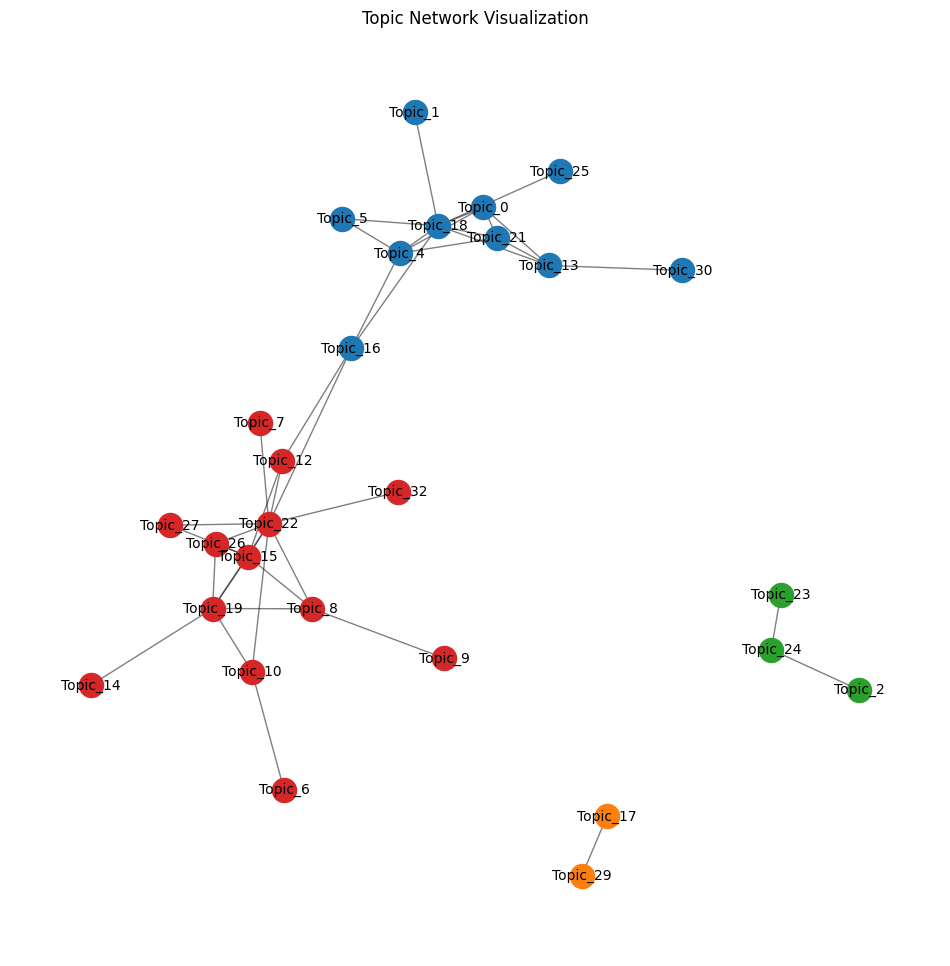

In [2]:
import os
import subprocess
import sys
import jieba
import re
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from community import community_louvain
import matplotlib.colors as mcolors

# 檢查 gcloud 是否安裝並設定專案
def check_gcloud(project_id):
    """檢查 gcloud 是否安裝並設定專案"""
    try:
        subprocess.run(["gcloud", "--version"], check=True, stdout=subprocess.PIPE)
        print("gcloud 已安裝")

        # 設定 gcloud 專案
        subprocess.run(["gcloud", "config", "set", "project", project_id], check=True)
        print(f"已設定專案為: {project_id}")
    except FileNotFoundError:
        print("gcloud 未安裝，請先安裝並配置。")
        sys.exit(1)
    except subprocess.CalledProcessError as e:
        print(f"設定 gcloud 專案失敗: {e}")
        sys.exit(1)

# 設置防火牆規則以允許 SSH
def setup_firewall():
    """設置防火牆規則以允許 SSH"""
    try:
        result = subprocess.run(
            ["gcloud", "compute", "firewall-rules", "list", "--filter", "name=default-allow-ssh"],
            check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        # 如果規則已存在，跳過創建
        if "default-allow-ssh" in result.stdout:
            print("防火牆規則已存在，跳過創建。")
            return

        # 創建防火牆規則
        subprocess.run([
            "gcloud", "compute", "firewall-rules", "create", "default-allow-ssh",
            "--allow", "tcp:22"
        ], check=True)
        print("防火牆規則已設置，允許 SSH 存取。")
    except subprocess.CalledProcessError as e:
        print(f"設置防火牆規則失敗: {e}")
        sys.exit(1)

# 創建 Compute Engine 實例
def create_compute_instance(instance_name, zone, machine_type, image_project, image_family):
    """創建 Compute Engine 實例"""
    try:
        # 檢查實例是否已存在
        result = subprocess.run(
            ["gcloud", "compute", "instances", "list", "--filter", f"name={instance_name}"],
            check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        if instance_name in result.stdout:
            print(f"Compute Engine 實例 {instance_name} 已存在，跳過創建。")
            return

        # 創建新的實例
        subprocess.run([
            "gcloud", "compute", "instances", "create", instance_name,
            "--zone", zone,
            "--machine-type", machine_type,
            "--image-project", image_project,
            "--image-family", image_family,
            "--boot-disk-size", "50GB"
        ], check=True)
        print(f"Compute Engine 實例 {instance_name} 創建完成。")
    except subprocess.CalledProcessError as e:
        print(f"創建 Compute Engine 實例失敗: {e}")
        sys.exit(1)

# 在實例中安裝 Docker
def setup_docker(instance_name, zone):
    """在實例中安裝 Docker"""
    try:
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", "sudo apt-get update && sudo apt-get install -y docker.io"
        ], check=True)
        print("Docker 安裝完成。")
    except subprocess.CalledProcessError as e:
        print(f"安裝 Docker 失敗: {e}")
        sys.exit(1)

# 驗證 Docker 鏡像是否可用
def validate_docker_image(instance_name, zone, docker_image):
    """檢查 Docker 鏡像是否有效"""
    try:
        print("檢查 Docker 鏡像是否存在...")
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", f"sudo docker pull {docker_image}"
        ], check=True)
        print("Docker 鏡像拉取成功。")
    except subprocess.CalledProcessError as e:
        print(f"Docker 鏡像無法拉取: {e}")
        print("請確保提供的 Docker 鏡像名稱正確，或進行 `docker login` 以獲取權限。")
        sys.exit(1)

# 部署 Docker 容器
def deploy_docker_container(instance_name, zone, docker_image):
    """部署 Docker 容器"""
    try:
        validate_docker_image(instance_name, zone, docker_image)

        deploy_command = f"sudo docker run -d {docker_image}"
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", deploy_command
        ], check=True)
        print("Docker 容器已部署並運行。")
    except subprocess.CalledProcessError as e:
        print(f"部署 Docker 容器失敗: {e}")
        sys.exit(1)

# 初始化 SparkSession
def initialize_spark():
    """初始化 SparkSession"""
    return SparkSession.builder.appName("PySpark LDA Analysis with TF-IDF").getOrCreate()

# 從文件中讀取停用詞
def load_stopwords(filepath):
    """從文件中讀取停用詞"""
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            return set(line.strip() for line in file)
    except FileNotFoundError:
        print(f"停用詞文件 {filepath} 未找到，請確認路徑是否正確。")
        sys.exit(1)

# 文本處理與分詞
def process_text(text, stopwords):
    """文本處理與分詞"""
    if text is None:
        return []
    words = jieba.cut(re.sub(r"[^\u4e00-\u9fa5]", "", text))
    return [word for word in words if word not in stopwords]

# 執行 LDA 分析
def lda_analysis(spark, csv_path, stopwords_path):
    """執行 LDA 分析"""
    stopwords = load_stopwords(stopwords_path)
    process_text_udf = udf(lambda text: process_text(text, stopwords), ArrayType(StringType()))

    # 加載數據
    data = spark.read.csv(csv_path, header=True, inferSchema=True)
    data = data.select('title', 'body').dropna()

    # 分詞與向量化
    data = data.withColumn("filtered_words", process_text_udf(data["body"]))
    vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=5000, minDF=5)
    vectorized_model = vectorizer.fit(data)
    vectorized_data = vectorized_model.transform(data)

    # 計算 TF-IDF
    idf = IDF(inputCol="features", outputCol="tfidf_features")
    idf_model = idf.fit(vectorized_data)
    tfidf_data = idf_model.transform(vectorized_data)

    # 計算困惑度並選擇最佳主題數量
    k_values = range(2, 51)
    perplexities = []
    for k in k_values:
        lda = LDA(k=k, maxIter=10, featuresCol="tfidf_features")
        model = lda.fit(tfidf_data)
        perplexities.append(model.logPerplexity(tfidf_data))

    # 繪製困惑度曲線
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, perplexities, marker="o")
    plt.title("LDA Perplexity vs Number of Topics (TF-IDF)")
    plt.xlabel("Number of Topics (k)")
    plt.ylabel("Log Perplexity")
    plt.show()

    # 選擇最佳主題數量
    optimal_k = k_values[np.argmin(perplexities)]
    lda = LDA(k=optimal_k, maxIter=10, featuresCol="tfidf_features")
    lda_model = lda.fit(tfidf_data)

    # 打印主題結果
    topics = lda_model.describeTopics(10).toPandas()
    vocab_list = vectorized_model.vocabulary
    topics["terms"] = topics["termIndices"].apply(lambda indices: [vocab_list[idx] for idx in indices])
    topics["weights"] = topics["termWeights"].apply(lambda weights: [round(w, 4) for w in weights])

    print("LDA 主題分析結果：")
    for i, row in topics.iterrows():
        keywords_with_weights = ", ".join(
            [f"{term}({weight})" for term, weight in zip(row["terms"], row["weights"])]
        )
        print(f"主題 {i}: {keywords_with_weights}")

    doc_topics = lda_model.transform(tfidf_data)
    doc_topics_pd = doc_topics.select("title", "topicDistribution").toPandas()
    doc_topics_pd["topicDistribution"] = doc_topics_pd["topicDistribution"].apply(
        lambda x: np.array(x, dtype=np.float64)
    )

    return lda_model, doc_topics_pd

# 可視化主題網絡
def visualize_topics(doc_topics_pd):
    """可視化主題網絡"""
    doc_topic_matrix = np.array(doc_topics_pd["topicDistribution"].tolist())
    cosine_sim = cosine_similarity(doc_topic_matrix.T)
    G = nx.Graph()

    # 建立網絡圖
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            if cosine_sim[i, j] > 0.1:
                G.add_edge(f"Topic_{i}", f"Topic_{j}", weight=cosine_sim[i, j])

    # 社區檢測
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    # 視覺化網絡圖
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 12))
    communities = nx.get_node_attributes(G, 'community')
    unique_communities = set(communities.values())
    color_map = list(mcolors.TABLEAU_COLORS.values())

    for community in unique_communities:
        nodes = [node for node in G.nodes if communities[node] == community]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=300,
                               node_color=color_map[community % len(color_map)])

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Topic Network Visualization")
    plt.axis('off')
    plt.show()

# 主程序入口
def main():
    """主程序"""
    project_id = "fakenewsbda"
    instance_name = "lda-analysis-instance"
    zone = "us-central1-a"
    machine_type = "e2-standard-4"
    image_project = "debian-cloud"
    image_family = "debian-11"
    docker_image = "python:3.12.3"

    # 初始化 GCP 環境
    check_gcloud(project_id)
    setup_firewall()
    create_compute_instance(instance_name, zone, machine_type, image_project, image_family)
    setup_docker(instance_name, zone)
    deploy_docker_container(instance_name, zone, docker_image)

    # 啟動 Spark 和執行分析
    spark = initialize_spark()
    csv_path = "/home/rrrrryeedie/final_sorted_output.csv"
    stopwords_path = "/home/rrrrryeedie/stopwords.txt"
    lda_model, doc_topics_pd = lda_analysis(spark, csv_path, stopwords_path)
    visualize_topics(doc_topics_pd)

if __name__ == "__main__":
    main()
